# FrozenLake 8x8 - UCB

This environment has 256 states. Because of this E-Greedy Agent takes a lot of episoded to learn the correct policy.
To speed it up in this notebook we use UCB Agent. Based on Upper-Confidence-Bound Action Selection.
For more information check [Sutton book](http://incompleteideas.net/sutton/book/bookdraft2016sep.pdf).

For this tutorial we will use [Frozen Lake 8x8](https://gym.openai.com/envs/FrozenLake8x8-v0).

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import wrappers

logging.getLogger('gym').setLevel(logging.WARNING)

## Helper functions

In [2]:
# FrozenLake is solved if moving average over window size 100 is >= 0.78
def moving_average(xs, n=100):
    ret = np.cumsum(xs, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def find_index(xs, v):
    """Find index of the first value equal or greater then v"""
    for i in range(len(xs)):
        if xs[i] >= v:
            return i
    return -1

## UCB Table Agent

The UCB tries to estimate the value function and variance for each action. 
Then action is selected based on both value and variance.

The formula to select action:

$$ A_t = argmax_{a} \left[ Q_t(a) + c \sqrt{ \frac{log(t)}{N_t(a)} } \right] $$

Where:
  * $\sqrt{ \frac{log(t)}{N_t(a)} }$ - Is variance (uncertainty) of action value
  * $N_t(a)$ - How many times this action was selected
  * c - controls the degree of exploration
  
The formula to learn:

$$ Q'_{a} = \frac{Q_{a}*(n-1) + r}{n} $$

In [23]:
class UCBAgent:
    
    def __init__(self, num_states, num_actions, c=2.0, gamma=0.95, alpha=0.8):
        self.Q = np.zeros([num_states, num_actions])
        self.counters = np.zeros([num_states, num_actions])
        self.c = c
        self.gamma = gamma
        self.alpha = alpha
        
    def choose_action(self, state, step):
        counters = self.counters[state,:]
        Q = self.Q[state,:]
        if np.min(counters) == 0:
            return np.argmin(counters)
        else:
            t = np.sum(counters)
            var = self.c * np.sqrt(np.log(t)/counters)
            return np.argmax(Q + var)
        
    def learn(self, state, action, reward, next_state):
        """Update state using Bellman equation"""
        r2 = reward + self.gamma * np.max(self.Q[next_state,:])
        self.Q[state, action] += self.alpha * (r2-self.Q[state, action])
        self.counters[state, action] += 1

## Train agent

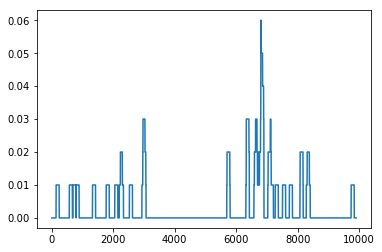

In [32]:
# Learning parameters
learning_rate = 0.8
gamma = 0.95
num_episodes = int(1e4)
solved_score = 0.99

# Environment
env = gym.make('FrozenLake8x8-v0')
# env = wrappers.Monitor(env, '../../../logs/qtable', force=True)

# Agent
agent = UCBAgent(env.observation_space.n, env.action_space.n)
# agent = QTableAgent(env.observation_space.n, env.action_space.n, gamma, learning_rate)

# Learn Q-Table
rewards = []
for episode in range(num_episodes):
    s = env.reset()
    total_reward = 0
    for j in range(1000):
        a = agent.choose_action(s, episode)
        s2, reward, done, _ = env.step(a)
        agent.learn(s, a, reward, s2)
        s = s2
        total_reward += reward
        if done:
            break
    rewards.append(total_reward)
    
env.close()    

# Show summary
averaged_rewards = moving_average(rewards)    
idx = find_index(averaged_rewards, solved_score)
if idx >= 0:
    print('Solved after {} episodes'.format(idx+1))

plt.plot(averaged_rewards)
plt.show()